In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Lexical Features

This section extracts the data from the merged-text-features.csv and preprocesses it for testing. We apply standard scaling for logistic regression.

In [2]:
text_detection_features = pd.read_csv("data/csv/merged-text-features.csv").drop(columns=["Total words_x", "Average words per sentence_x"]).set_index('Id')
X = text_detection_features.drop(columns=['Label'])
y = text_detection_features['Label']

standard_scale = StandardScaler()
X = standard_scale.fit_transform(X)

label_encoder = LabelEncoder()

# 0 = Chatgpt | 1 = Human
y = label_encoder.fit_transform(y)

X_extract_train, X_extract_test, y_extract_train, y_extract_test = train_test_split(X, y, test_size=0.2, random_state=42)

# PCA Feature analysis

In [3]:
# Extracting best features based on PCA
pca = PCA(n_components=21)
pca_fit = pca.fit(X)

data = text_detection_features.drop(columns=['Label'])
features = data.columns

most_important = [np.abs(pca_fit.components_[i]).argmax() for i in range(21)]
most_important_values = [np.abs(pca_fit.components_[i]).max() for i in range(21)]
most_important_names = [features[most_important[i]] for i in range(21)]
dic = {most_important_names[i]: most_important_values[i] for i in range(21)}
df = pd.DataFrame(dic.items())
df[1] = df[1]/df[1].max()
# df

Text(0, 0.5, 'Variance ratio')

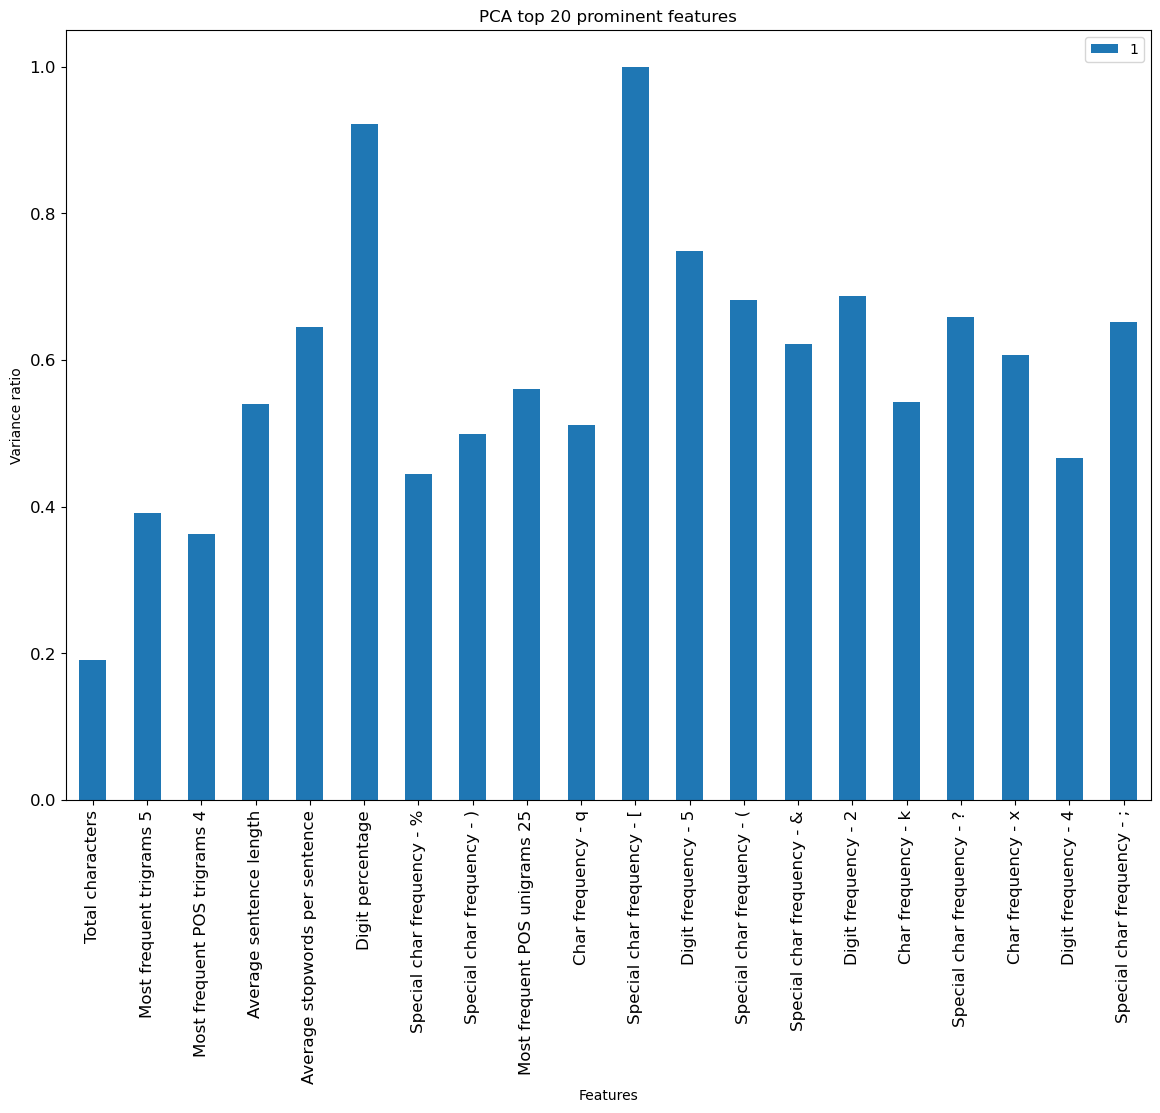

In [28]:
df.plot(x=0, y=1, kind='bar', title ="PCA top 20 prominent features", figsize=(14, 10), legend=True, fontsize=12)
plt.xlabel('Features')
plt.ylabel('Variance ratio')

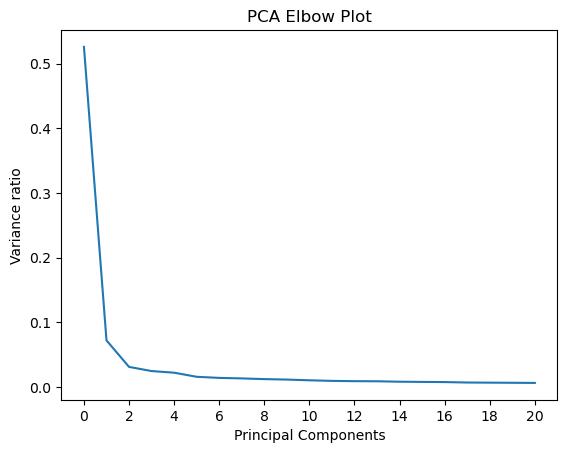

In [26]:
import matplotlib.ticker as ticker
componentId = np.arange(0, 21)

fig, ax = plt.subplots()

ax.plot(componentId, pca.explained_variance_ratio_)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=2))
plt.title('PCA Elbow Plot')
plt.xlabel('Principal Components')
plt.ylabel('Variance ratio')

plt.show()

# Preprocessing extracted features after PCA

In [6]:
text_detection_features = pd.read_csv("data/csv/merged-text-features.csv").drop(columns=["Total words_x", "Average words per sentence_x"]).set_index('Id')
X_two_pca = text_detection_features.drop(columns=['Label'])[['Total characters', 'Most frequent trigrams 5']]
y_two_pca = text_detection_features['Label']

standard_scale = StandardScaler()
X_two_pca = standard_scale.fit_transform(X_two_pca)

label_encoder = LabelEncoder()

# 0 = Chatgpt | 1 = Human
y_two_pca = label_encoder.fit_transform(y_two_pca)

X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_two_pca, y_two_pca, test_size=0.2, random_state=42)

In [7]:
text_detection_features

,Total OOV words,Average OOV words,Most frequent unigrams 1,Most frequent unigrams 2,Most frequent unigrams 3,Most frequent unigrams 4,Most frequent unigrams 5,Most frequent unigrams 6,Most frequent bigrams 1,Most frequent bigrams 2,...,Most frequent POS trigrams 2,Most frequent POS trigrams 3,Most frequent POS trigrams 4,Most frequent POS trigrams 5,Most frequent POS trigrams 6,Most frequent POS trigrams 7,Most frequent POS trigrams 8,Total sentences,Average sentence length,Flesch-kincaid grade level score
Id,,,,,,,,,,,,,,,,,,,,,
1,65,0.145455,6,5,5,5,5,4,4,3,...,5,5,5,5,4,4,4,10,169.600000,14.594079
2,65,0.107595,12,12,6,5,5,5,12,4,...,8,8,7,6,6,5,5,14,137.642857,13.004951
3,105,0.142500,11,11,9,6,5,5,5,4,...,9,8,7,7,6,6,6,17,145.352941,12.475484
4,73,0.092105,9,9,9,8,7,5,9,8,...,9,9,8,8,7,6,6,14,136.000000,13.735129
5,85,0.109785,14,12,9,8,7,5,12,7,...,7,7,7,6,6,5,5,17,147.352941,12.347429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,57,0.063433,5,4,4,4,3,3,2,2,...,5,4,4,3,3,3,3,18,84.777778,8.494828
249,71,0.068750,9,6,6,6,5,3,2,2,...,13,10,10,9,8,6,5,15,170.600000,13.409583
250,120,0.119403,9,7,5,5,5,4,2,2,...,7,7,7,7,6,6,6,26,121.384615,10.876382


# TFIDF dataset creation

In [12]:
tfidf_features = pd.read_csv("data/csv/TFIDF-features.csv").set_index('Id')

X_tfidf = tfidf_features.drop(columns=['Label'])
y_tfidf = tfidf_features['Label']

standard_scale = StandardScaler()
X_tfidf = standard_scale.fit_transform(X_tfidf)

label_encoder = LabelEncoder()
# 0 = Chatgpt | 1 = Human
y_tfidf = label_encoder.fit_transform(y_tfidf)


X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(X_tfidf, y_tfidf, test_size=0.2, random_state=42)

# Paper experiment recreation evaluation

## PCA filtered features - XGBoost

In [23]:
xgBoost = xgb.XGBClassifier()

print('Extracted text-features')
print(f'XGBoost Accuracy: {np.mean(cross_val_score(xgBoost, X_pca_train, y_pca_train, cv=5, scoring="accuracy")):.4f}')
print(f'XGBoost Precision: {np.mean(cross_val_score(xgBoost, X_pca_train, y_pca_train, cv=5, scoring="precision")):.4f}')
print(f'XGBoost Recall: {np.mean(cross_val_score(xgBoost, X_pca_train, y_pca_train, cv=5, scoring="recall")):.4f}')
print(f'XGBoost F1: {np.mean(cross_val_score(xgBoost, X_pca_train, y_pca_train, cv=5, scoring="f1")):.4f}')

Extracted text-features
XGBoost Accuracy: 0.7516
XGBoost Precision: 0.7506
XGBoost Recall: 0.7748
XGBoost F1: 0.7614


##  Lexical Features - Logistic Regression

In [10]:
lr = LogisticRegression()
print('Extracted text-features')
print(f'Logistic Regression Accuracy: {np.mean(cross_val_score(lr, X_extract_train, y_extract_train, cv=5, scoring="accuracy")):.4f}')
print(f'Logistic Regression Precision: {np.mean(cross_val_score(lr, X_extract_train, y_extract_train, cv=5, scoring="precision")):.4f}')
print(f'Logistic Regression Recall: {np.mean(cross_val_score(lr, X_extract_train, y_extract_train, cv=5, scoring="recall")):.4f}')
print(f'Logistic Regression F1: {np.mean(cross_val_score(lr, X_extract_train, y_extract_train, cv=5, scoring="f1")):.4f}')


Extracted text-features
Logistic Regression Accuracy: 0.9305
Logistic Regression Precision: 0.9599
Logistic Regression Recall: 0.9029
Logistic Regression F1: 0.9297


##  Lexical Features - XGBoost

In [11]:
xgBoost = xgb.XGBClassifier()

print('Extracted text-features')
print(f'XGBoost Accuracy: {np.mean(cross_val_score(xgBoost, X_extract_train, y_extract_train, cv=5, scoring="accuracy")):.4f}')
print(f'XGBoost Precision: {np.mean(cross_val_score(xgBoost, X_extract_train, y_extract_train, cv=5, scoring="precision")):.4f}')
print(f'XGBoost Recall: {np.mean(cross_val_score(xgBoost, X_extract_train, y_extract_train, cv=5, scoring="recall")):.4f}')
print(f'XGBoost F1: {np.mean(cross_val_score(xgBoost, X_extract_train, y_extract_train, cv=5, scoring="f1")):.4f}')


Extracted text-features
XGBoost Accuracy: 0.9155
XGBoost Precision: 0.9101
XGBoost Recall: 0.9314
XGBoost F1: 0.9190


## TFIDF - Logistic Regression

In [13]:
lr = LogisticRegression()
print(f'TFIDF')
print(f'Logistic Regression Accuracy: {np.mean(cross_val_score(lr, X_tfidf_train, y_tfidf_train, cv=5, scoring="accuracy")):.4f}')
print(f'Logistic Regression Precision: {np.mean(cross_val_score(lr, X_tfidf_train, y_tfidf_train, cv=5, scoring="precision")):.4f}')
print(f'Logistic Regression Recall: {np.mean(cross_val_score(lr, X_tfidf_train, y_tfidf_train, cv=5, scoring="recall")):.4f}')
print(f'Logistic Regression F1: {np.mean(cross_val_score(lr, X_tfidf_train, y_tfidf_train, cv=5, scoring="f1")):.4f}')


TFIDF
Logistic Regression Accuracy: 0.9404
Logistic Regression Precision: 0.9705
Logistic Regression Recall: 0.9129
Logistic Regression F1: 0.9389


## TFIDF - XGBoost

In [14]:
xgBoost = xgb.XGBClassifier()
# xgBoost.fit(X_train, y_train)
print(f'TFIDF')
print(f'XGBoost Accuracy: {np.mean(cross_val_score(xgBoost, X_tfidf_train, y_tfidf_train, cv=5, scoring="accuracy")):.4f}')
print(f'XGBoost Precision: {np.mean(cross_val_score(xgBoost, X_tfidf_train, y_tfidf_train, cv=5, scoring="precision")):.4f}')
print(f'XGBoost Recall: {np.mean(cross_val_score(xgBoost, X_tfidf_train, y_tfidf_train, cv=5, scoring="recall")):.4f}')
print(f'XGBoost F1: {np.mean(cross_val_score(xgBoost, X_tfidf_train, y_tfidf_train, cv=5, scoring="f1")):.4f}')


TFIDF
XGBoost Accuracy: 0.8754
XGBoost Precision: 0.9229
XGBoost Recall: 0.8243
XGBoost F1: 0.8692


# Hyperparameter tuning

In [15]:
from sklearn.model_selection import GridSearchCV

## XGBoost - PCA Filtered Features

In [16]:
used_parameters = {
    'learning_rate': [0.1, .2,.5, 1],
    'max_depth': [2, 3, 5, 7, 10, 15, None],
    'max_leaves': [2, 3, 5, 7, 10, 15, None],
#     'subsample': [None, 0, .5],
#     'colsample_bytree': [None, 0, .5],
#     'colsample_bynode': [None, 0, .5],
#     'colsample_bylevel': [None, 0, .5],
    'gamma': [None, 0.5, 1.0],
    'reg_lambda': [None, 5.0, 10],
#     'reg_alpha': [None, 5.0, 10],
}

In [17]:
# parameters = {
#     'learning_rate': [0.1, 0.05, 0.2],
#     'max_depth': [1,2],
#     'max_leaves': [1,2],
# #     'subsample': [None, 0, .5],
# #     'colsample_bytree': [None, 0, .5],
# #     'colsample_bynode': [None, 0, .5],
# #     'colsample_bylevel': [None, 0, .5],
#     'gamma': [None, 0.5, 1.0],
#     'reg_lambda': [None, 2, 5.0, 10],
#     'reg_alpha': [None, 2, 5.0, 10],
# }

# xgBoost = xgb.XGBClassifier(n_jobs=-1)
 
# grid_cv = GridSearchCV(xgBoost, parameters, cv=3)
# grid_cv.fit(X_pca_train, y_pca_train)

In [18]:
# best_params = grid_cv.best_params_
best_params = {'gamma': 1.0,
 'learning_rate': 0.1,
 'max_depth': 1,
 'max_leaves': 2,
 'reg_alpha': None,
 'reg_lambda': None}

# Final evaluation

## Lexical features - XGBoost

In [19]:
xgBoost = xgb.XGBClassifier()
xgBoost.fit(X_extract_train, y_extract_train)
xgBoost_predicted = xgBoost.predict(X_extract_test)

print(f'XGBoost Accuracy: {xgBoost.score(X_extract_test, y_extract_test):.4f}')
print(f'XGBoost Precision: {precision_score(xgBoost_predicted, y_extract_test):.4f}')
print(f'XGBoost Recall: {recall_score(xgBoost_predicted, y_extract_test):.4f}')
print(f'XGBoost F1: {f1_score(xgBoost_predicted, y_extract_test):.4f}')

XGBoost Accuracy: 0.9020
XGBoost Precision: 0.9583
XGBoost Recall: 0.8519
XGBoost F1: 0.9020


## PCA filtered features - XGBoost with most optimal hyperparameters

In [20]:
xgBoost = xgb.XGBClassifier(**best_params)
xgBoost.fit(X_pca_train, y_pca_train)
xgBoost_predicted = xgBoost.predict(X_pca_test)

print(f'XGBoost Accuracy: {xgBoost.score(X_pca_test, y_pca_test):.4f}')
print(f'XGBoost Precision: {precision_score(xgBoost_predicted, y_pca_test):.4f}')
print(f'XGBoost Recall: {recall_score(xgBoost_predicted, y_pca_test):.4f}')
print(f'XGBoost F1: {f1_score(xgBoost_predicted, y_pca_test):.4f}')

XGBoost Accuracy: 0.7843
XGBoost Precision: 0.8750
XGBoost Recall: 0.7241
XGBoost F1: 0.7925
